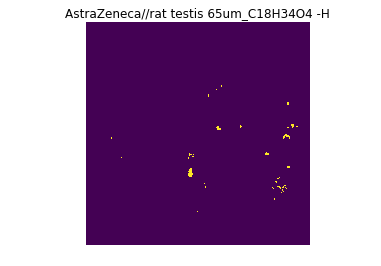

In [1]:
# SET SUMFORMULA NAME, ADDUCT, DATASET for selecting the region
sf_name = 'C18H34O4'
add_name = '-H'
ds_name = 'AstraZeneca//rat testis 65um'

# model param : tfidf or lsi
model = "lsi"
# quantile param
q = 90.
# ion intensity threshold param (-1 = above quantile)
i = 300000

import os
# base dir
base_dir = '/home/katya/Projects/Metabol/'

c_file = os.path.join(base_dir,'corpora/pixel_'+model+'.mm')
sim_file = os.path.join(base_dir,'pixel_similarity_models/'+model+'.index')
odir = os.path.join(base_dir,'genpics/simpics_'+model+'/')

pix_ann_dir = os.path.join(base_dir,'pixel-annotations/45_selected/')

sf_file = os.path.join(pix_ann_dir,'sf_df.msgpack')
dp_file = os.path.join(pix_ann_dir,'ds_pix_cord.msgpack')
dsf_file = os.path.join(pix_ann_dir,'ds_ion_int.msgpack')

import sys  
sys.path.append(base_dir)

import select_region
from select_region import sfname2index

ion_id = sfname2index(sf_file, sf_name, add_name)

from datetime import datetime
from select_region import select_region, viz_region

pixel_ids = select_region(dsf_file, ds_name, ion_id, q, i)
viz_region(dp_file, pixel_ids, ds_name, sf_name+' '+add_name, None)

In [4]:
import gensim
from gensim import corpora
from gensim import similarities
from gensim.similarities import Similarity

import similarities4region
from similarities4region import average_weight4group
from similarities4region import gen_sim_corpus

corpus = gensim.corpora.MmCorpus(c_file)
query_bow = average_weight4group(pixel_ids,corpus)
print(str(datetime.now()) + ': query_bow generated')
sim_corpus = gen_sim_corpus(sim_file, query_bow)
print(str(datetime.now()) + ': sim_corpus generated')

/usr/local/lib/python3.5/dist-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


2017-05-05 12:11:13.040463: query_bow generated
2017-05-05 12:11:16.238491: sim_corpus generated


In [5]:
import pandas
import numpy
import matplotlib.pyplot as plt

smin = sim_corpus.min(axis=0)
smax = sim_corpus.max(axis=0)

print("Similarity min = %f, max = %f" % (smin, smax))

images = []

dp_iterator = pandas.read_msgpack(dp_file, iterator = True)
for ds_name, df in dp_iterator:
    max_x = df['x'].max()
    max_y = df['y'].max()
    arr = numpy.zeros([max_x+1, max_y+1])

    for row in df.itertuples():
        arr[row[1]][row[2]] = sim_corpus[row[0]]

    arr = numpy.rot90(arr, 1)
    
    #plt.pcolormesh(arr, vmin=smin, vmax=smax, cmap='viridis')
    plt.pcolormesh(arr, cmap='viridis')
    plt.axes().set_aspect('equal', 'datalim')
    plt.axes().axis('off')
    plt.title(ds_name)
    plt.colorbar()
    i_path = os.path.join(odir,ds_name.replace('/','!'))
    images.append(i_path)
    plt.savefig(i_path, bbox_inches='tight')
    plt.clf()

Similarity min = -0.001949, max = 0.981251


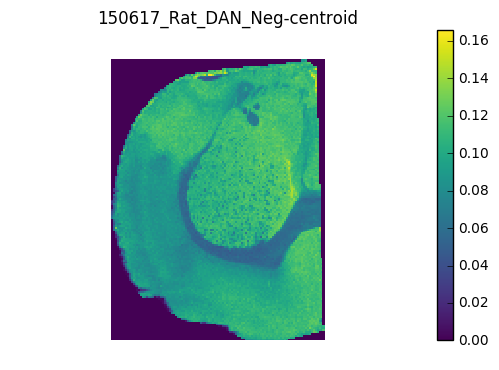

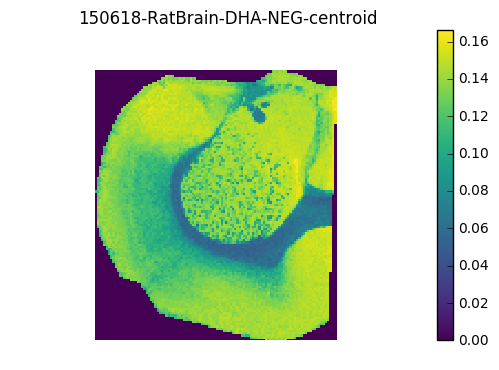

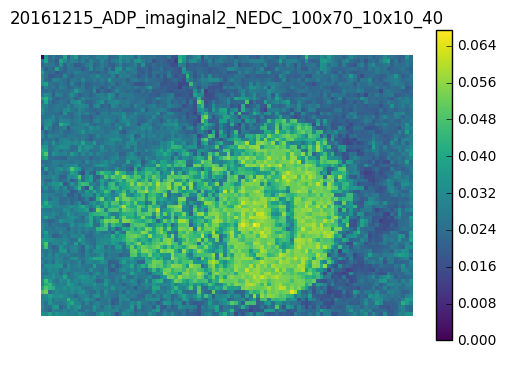

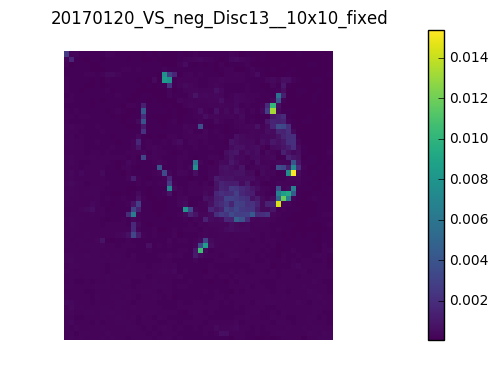

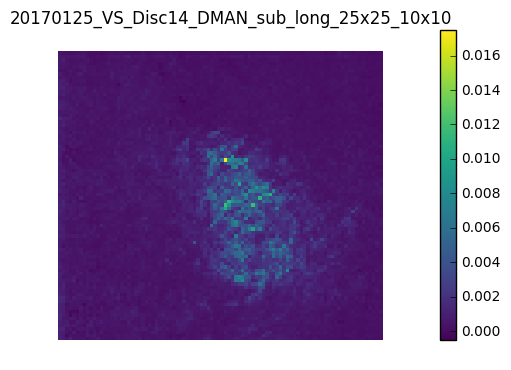

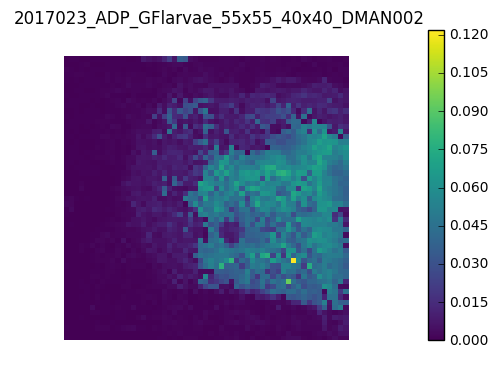

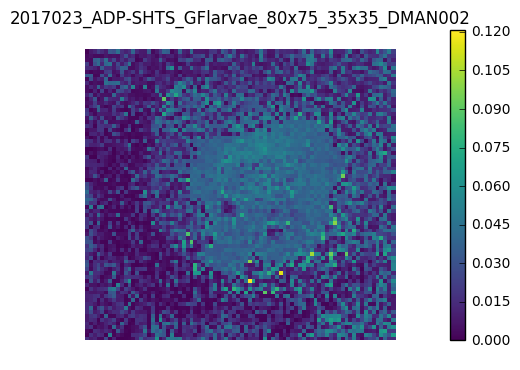

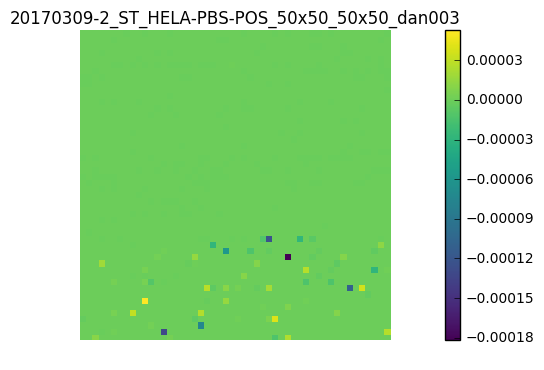

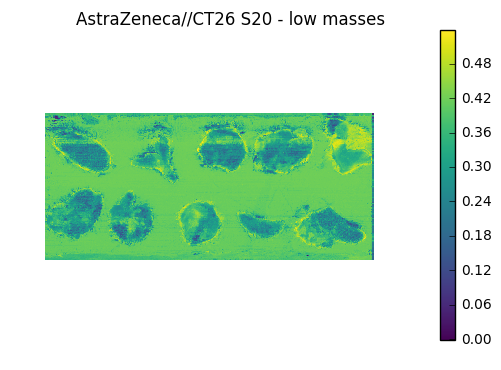

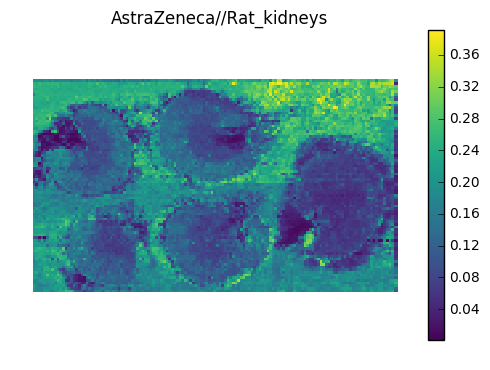

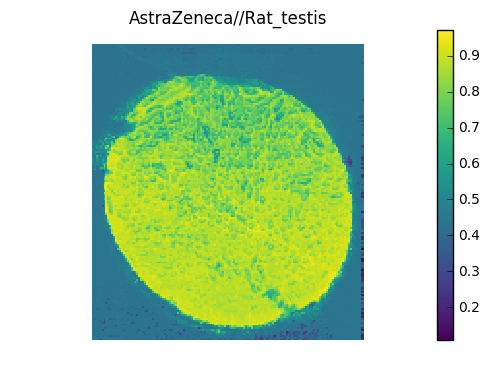

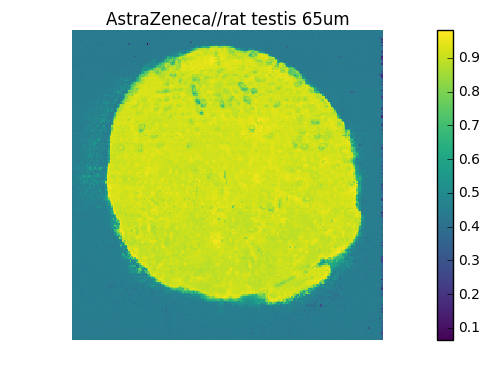

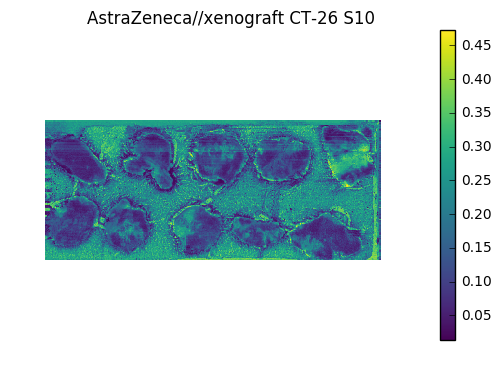

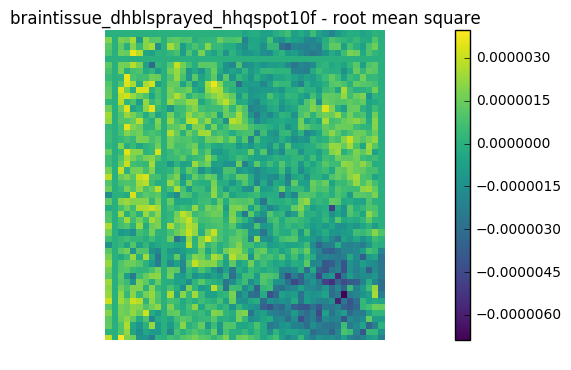

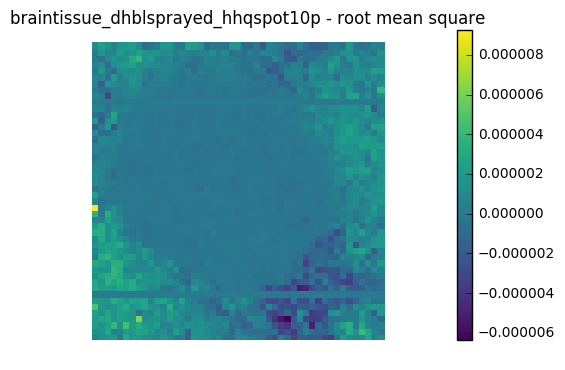

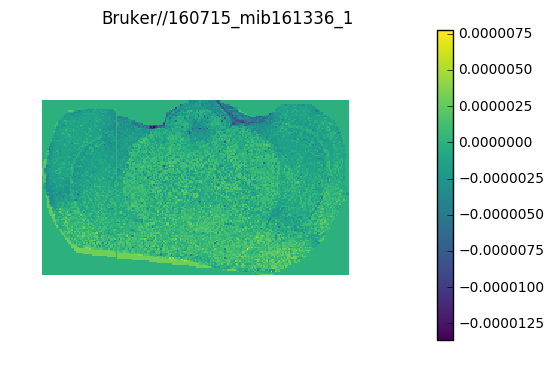

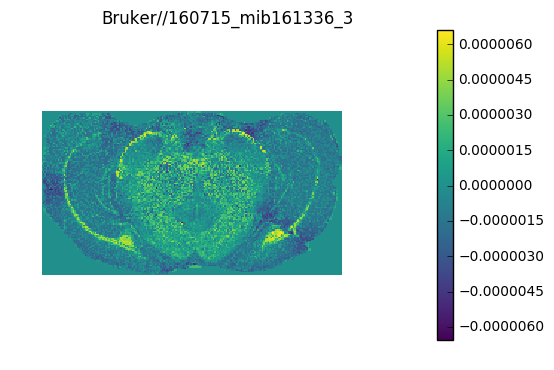

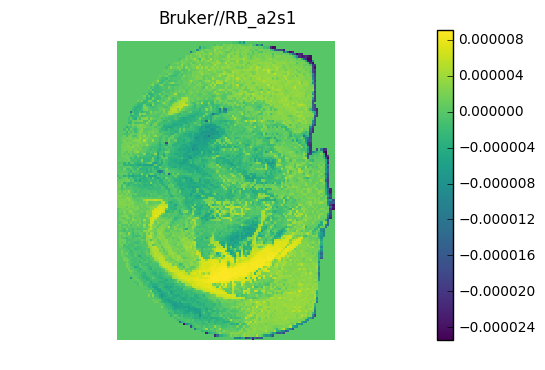

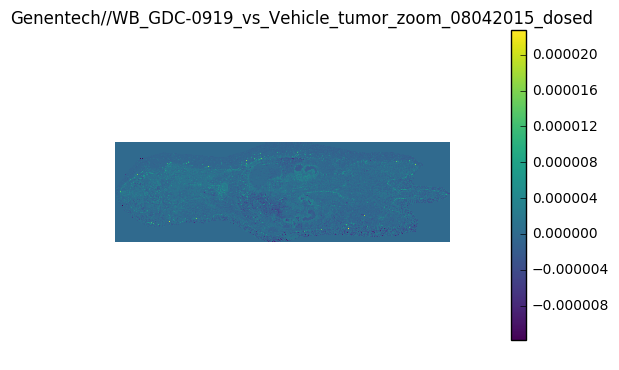

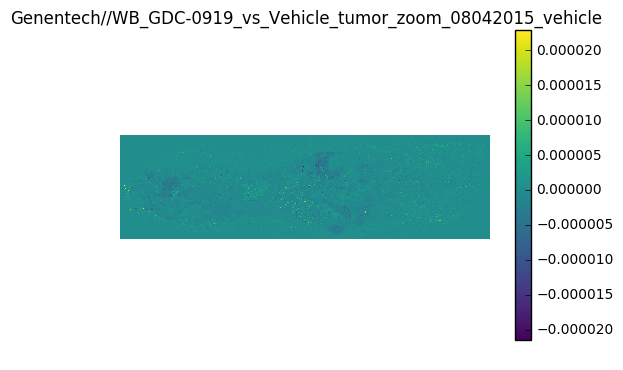

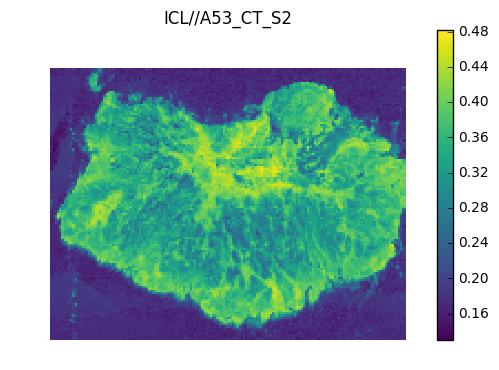

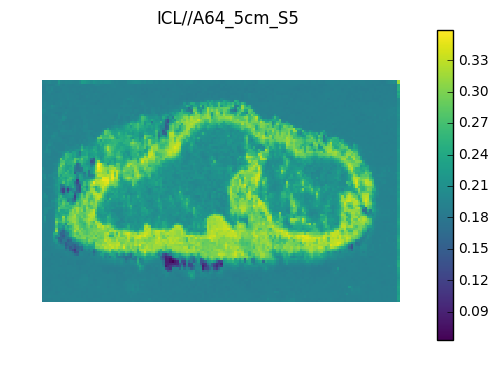

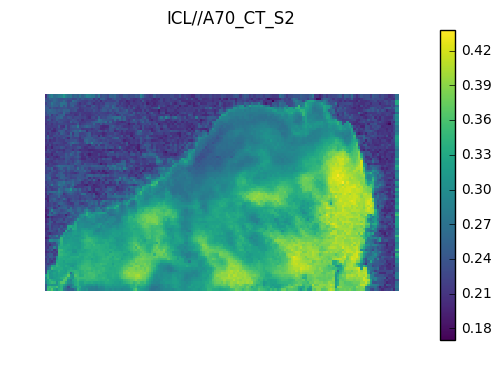

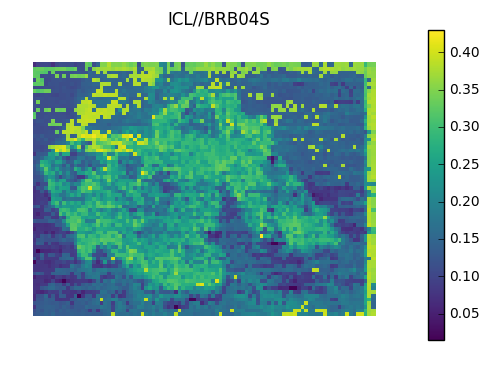

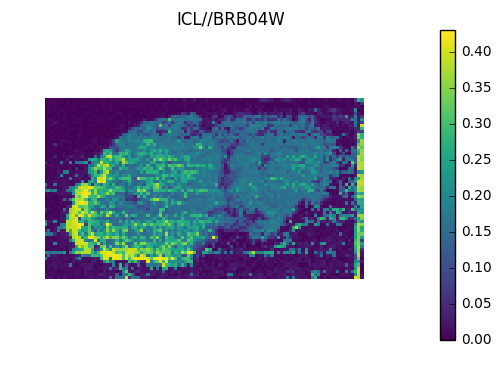

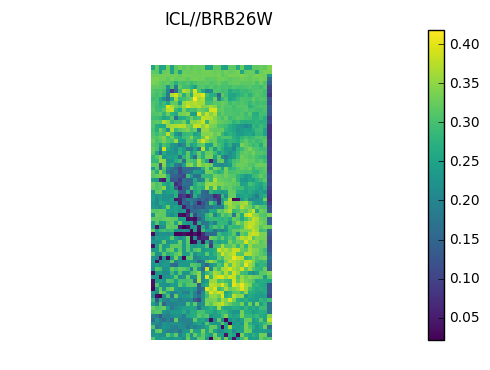

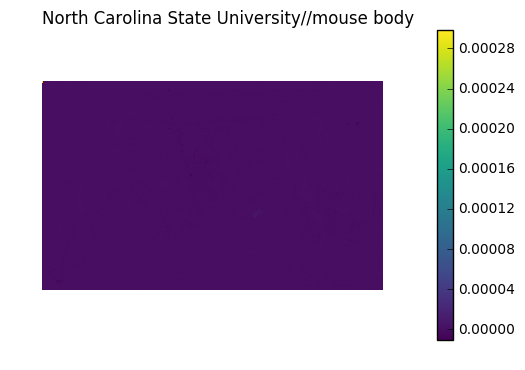

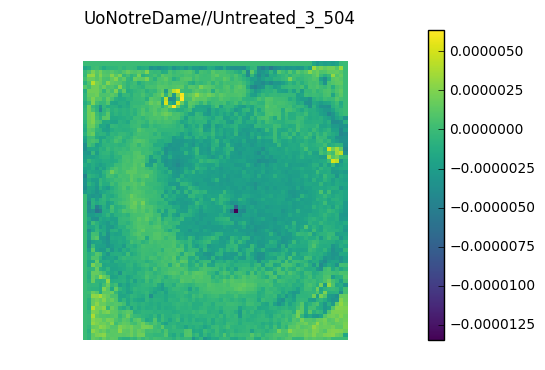

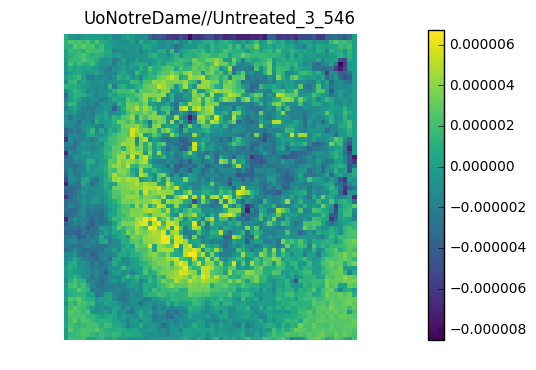

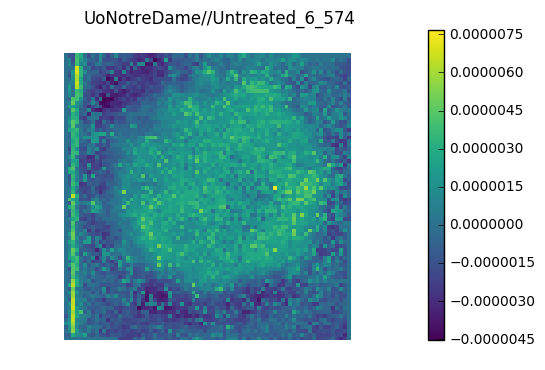

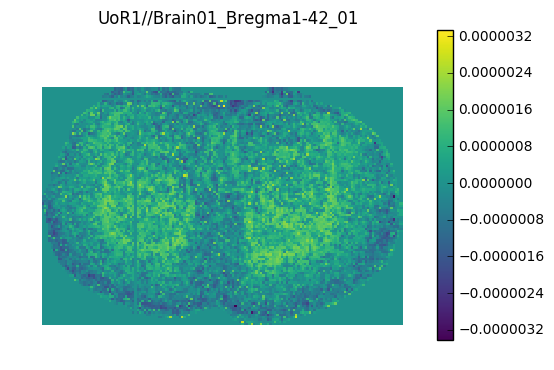

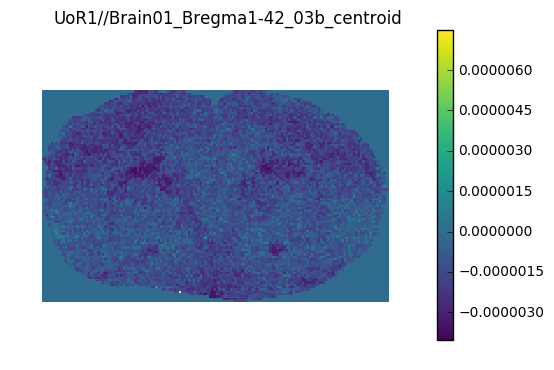

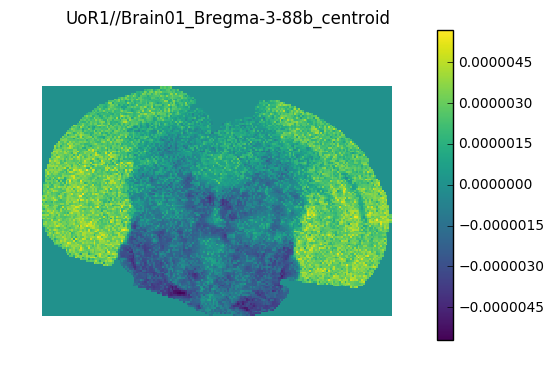

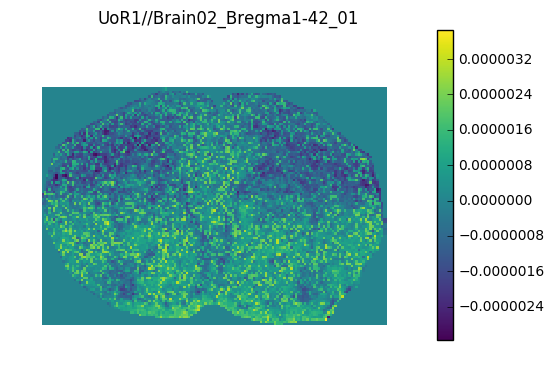

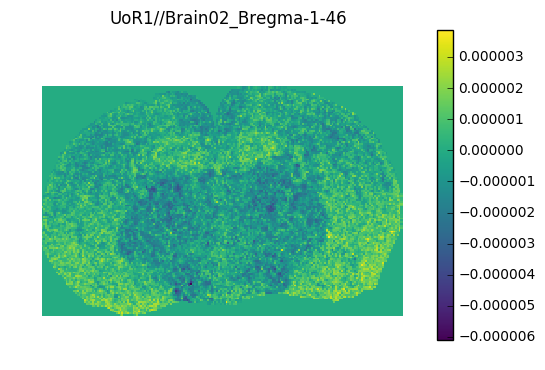

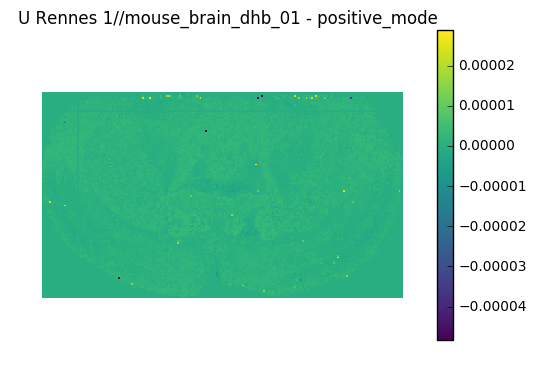

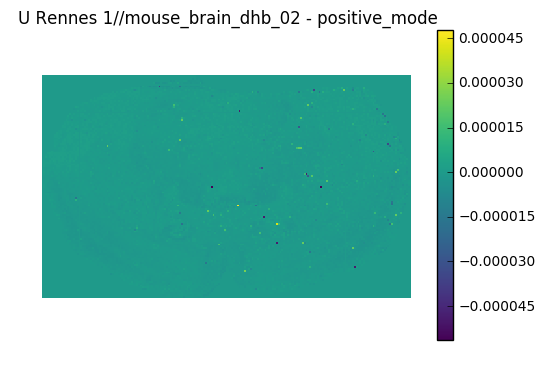

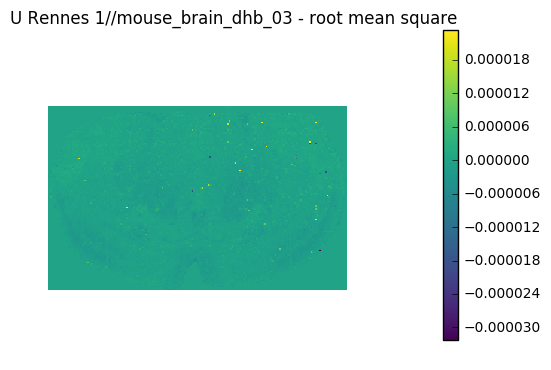

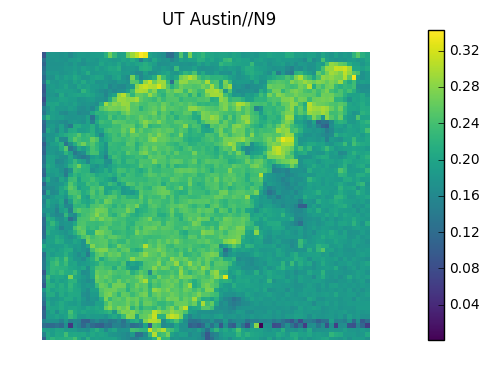

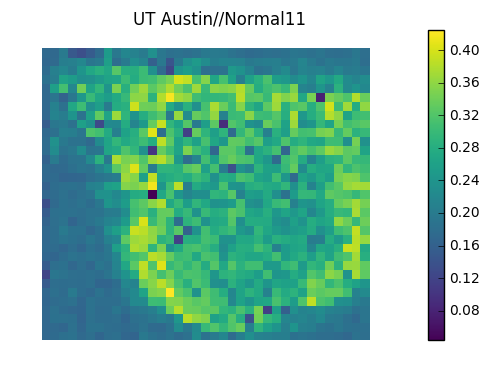

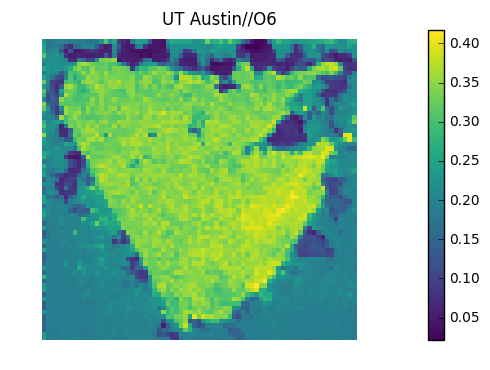

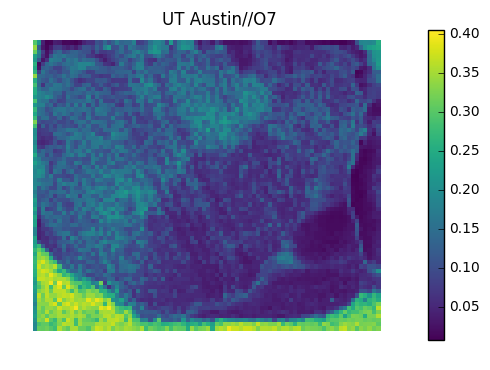

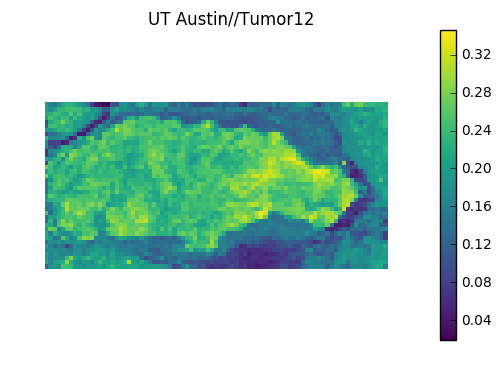

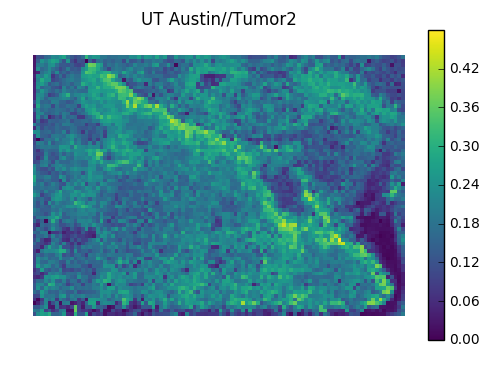

In [10]:
from IPython.display import Image, display

for i_path in images:
    display(Image(filename=i_path+'.png'))